<a href="https://colab.research.google.com/github/AliAlBadra/KerasTFImageClassificationCNN/blob/main/CellSeg_UNet_ResNet34_W_Patchify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prepare The Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation-models
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install patchify
!pip install scikit-learn==1.0.0
!pip install split-folders
!pip install gast==0.3.2
!pip install six==1.15.0
!pip install folium==0.2.1
!pip install imgaug==0.2.5
!pip install 'h5py<3.0.0'


     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 421.8 MB 27 kB/s 
     |████████████████████████████████| 3.8 MB 43.5 MB/s 
     |████████████████████████████████| 448 kB 31.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=d858a4c1be6e41d91ff0471a0d9cfbe7bd80b36563a0692a838999063a231c3b
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [1]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.0
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: threadpoolctl, scipy, joblib, numpy
Required-by: yellowbrick, sklearn, sklearn-pandas, mlxtend, lightgbm, librosa, imbalanced-learn


In [2]:
import os
import cv2
import numpy as np
import glob

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [5]:
cellseg_dir = '/content/drive/MyDrive/CellSeg/'
data_dir = cellseg_dir + "data/"
input_dir = data_dir + "input/"
original_input_dir = input_dir + "original/"
after_patchify_input_dir = input_dir + "after_patchify/"
output_dir = data_dir + "output/"


Labels are:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 2

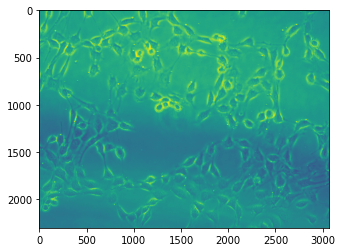

In [ ]:
#Quick understanding of the dataset
temp_img = cv2.imread(original_input_dir + "images/exp1.png") #3 channels / spectral bands
plt.imshow(temp_img[:,:,2]) #View each channel...
temp_mask = cv2.imread(original_input_dir +"masks/exp1-mask.png") #3 channels but all same. 
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)


In [ ]:
#Now, crop each large image into patches of 256x256. Save them into a directory 
#so we can use data augmentation and read directly from the drive. 
#root_directory = drive_dir

patch_size = 384

In [ ]:
#Read images from repsective 'images' subdirectory
#As all images are of different size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
img_dir= original_input_dir + "images/"
for path, subdirs, files in os.walk(img_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    #print(dirname)
    images = os.listdir(path)  #List of all image names in this subdirectory
    #print(images)
    for i, image_name in enumerate(sorted(images)):  
        if image_name.endswith(".png"):
            #print(image_name)
            image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
            SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)             
   
            #Extract patches from each image
            print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #We will preprocess using one of the backbones
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                    
                    cv2.imwrite(after_patchify_input_dir+"images/"+
                               image_name.rsplit('.', 1)[0]+"patch_"+str(i)+str(j)+".png", single_patch_img)
                    #image_dataset.append(single_patch_img)

Now patchifying image: /content/drive/MyDrive/CellSeg/data/input/original/images//exp1.png
Now patchifying image: /content/drive/MyDrive/CellSeg/data/input/original/images//exp2.png
Now patchifying image: /content/drive/MyDrive/CellSeg/data/input/original/images//exp3.png
Now patchifying image: /content/drive/MyDrive/CellSeg/data/input/original/images//exp4.png
Now patchifying image: /content/drive/MyDrive/CellSeg/data/input/original/images//exp5.png
Now patchifying image: /content/drive/MyDrive/CellSeg/data/input/original/images//exp6.png
Now patchifying image: /content/drive/MyDrive/CellSeg/data/input/original/images//exp7.png


In [ ]:
#Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dir = original_input_dir + "masks/"
for path, subdirs, files in os.walk(mask_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)  #List of all image names in this subdirectory
    for i, mask_name in enumerate(sorted(masks)):  
        if mask_name.endswith(".png"):           
            mask = cv2.imread(path+"/"+mask_name, 0)  #Read each image as Grey (or color but remember to map each color to an integer)
            SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            mask = Image.fromarray(mask)
            mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            mask = np.array(mask)             
            #Need to binarize the image. Simple thresholding for values above 0. 
            #Convert all values above 0 to 1 to assign a pixel value of 1 for the Houses class.
            #Similarly convert other values for other classes to 2, 3, etc. 
            mask = np.where(mask>0, 1, mask)
            #Extract patches from each image
            print("Now patchifying mask:", path+"/"+mask_name)
            patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    
                    single_patch_mask = patches_mask[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                    #single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                    cv2.imwrite(after_patchify_input_dir+"masks/"+
                               mask_name.rsplit('.', 1)[0]+"patch_"+str(i)+str(j)+".png", single_patch_mask)

Now patchifying mask: /content/drive/MyDrive/CellSeg/data/input/original/masks//exp1-mask.png
Now patchifying mask: /content/drive/MyDrive/CellSeg/data/input/original/masks//exp2-mask.png
Now patchifying mask: /content/drive/MyDrive/CellSeg/data/input/original/masks//exp3-mask.png
Now patchifying mask: /content/drive/MyDrive/CellSeg/data/input/original/masks//exp4-mask.png
Now patchifying mask: /content/drive/MyDrive/CellSeg/data/input/original/masks//exp5-mask.png
Now patchifying mask: /content/drive/MyDrive/CellSeg/data/input/original/masks//exp6-mask.png
Now patchifying mask: /content/drive/MyDrive/CellSeg/data/input/original/masks//exp7-mask.png


In [ ]:
train_img_dir = after_patchify_input_dir+"images/"
train_mask_dir = after_patchify_input_dir+"masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

/content/drive/MyDrive/CellSeg/data/input/after_patchify/images/exp2patch_21.png


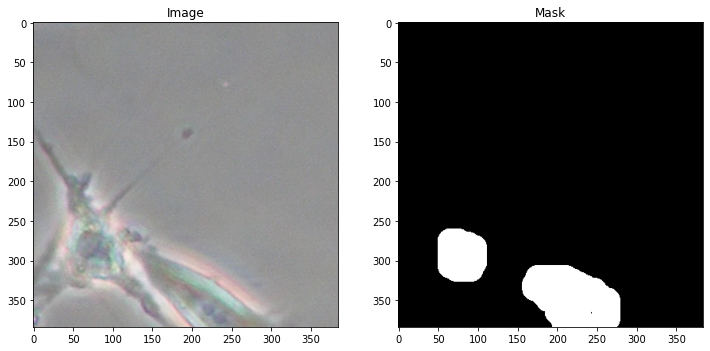

[0 1]


In [ ]:
img_num = random.randint(0, num_images-1)
img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)
print(train_img_dir+img_list[img_num])
mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

#Make sure mask only has values 0 & 1 (Binary mask)
print(np.unique(mask_for_plot))

In [ ]:
###############################################################
#Now split the data into training, validation and testing. 

"""
Code for splitting folder into train, test, and val.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators. 
pip install split-folders
"""
import splitfolders  # or import split_folders

input_folder = after_patchify_input_dir
output_folder = output_dir
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values
########################################

Copying files: 672 files [00:12, 52.67 files/s]


In [ ]:
########################################

#Now manually move folders around to bring them to the following structure.
"""
Your current directory structure:
CellSeg/
        data/
            train/
                images/
                    img1, img2, ...
                masks/
                    msk1, msk2, ....
            val/
                images/
                    img1, img2, ...
                masks/
                    msk1, msk2, ....
        
Copy the folders around to the following structure... 
CellSeg/data/
    train_images/
                train/
                    img1, img2, img3, ......
    
    train_masks/
                train/
                    msk1, msk, msk3, ......
                    
    val_images/
                val/
                    img1, img2, img3, ......                
    val_masks/
                val/
                    msk1, msk, msk3, ......
      
                    
"""

# Data Augmentation

In [6]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random


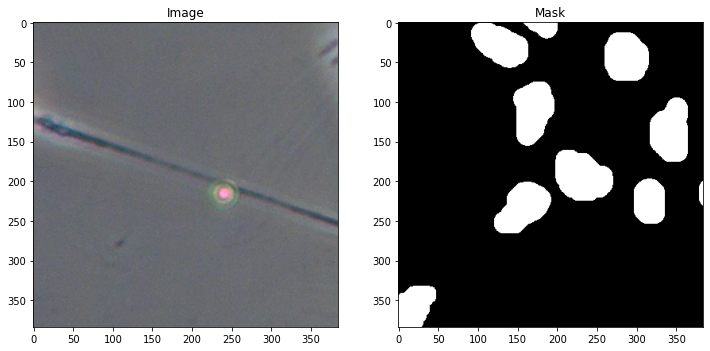

384 384 3


In [7]:
################################################################
#Get an understanding by looking at a few random images and masks 

train_img_dir = output_dir + "train_images/train/"
train_mask_dir = output_dir + "train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

height, width, channels = img_for_plot.shape
print (height, width, channels)

In [8]:
# Define Generator for images and masks so we can read them directly from the drive. 

seed=24
batch_size= 16
n_classes=2

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.clip = False
from keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

train_img_path = output_dir + "train_images/"
train_mask_path = output_dir + "train_masks/"

val_img_path = output_dir + "val_images/"
val_mask_path = output_dir + "val_masks/"


In [9]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.0
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, joblib, threadpoolctl, numpy
Required-by: yellowbrick, sklearn, sklearn-pandas, mlxtend, lightgbm, librosa, imbalanced-learn


In [10]:
#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

In [11]:
#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    while True:
      img_data_gen_args = dict(horizontal_flip=True,
                        vertical_flip=True,
                        fill_mode='reflect')
      
      image_datagen = ImageDataGenerator(**img_data_gen_args)
      mask_datagen = ImageDataGenerator(**img_data_gen_args)
      
      image_generator = image_datagen.flow_from_directory(
          train_img_path,
          class_mode = None,
          batch_size = batch_size,
          seed = seed)
      
      mask_generator = mask_datagen.flow_from_directory(
          train_mask_path,
          class_mode = None,
          color_mode = 'grayscale',
          batch_size = batch_size,
          seed = seed)
      
      train_generator = zip(image_generator, mask_generator)
      i = 0
      for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [12]:
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=n_classes)
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes)

Found 252 images belonging to 1 classes.
Found 252 images belonging to 1 classes.


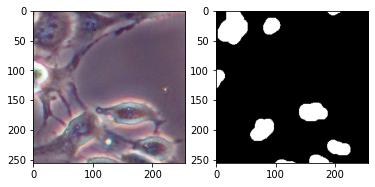

256 256 3


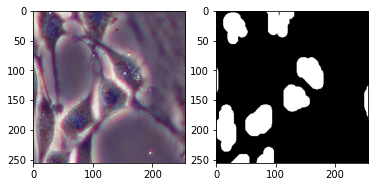

256 256 3


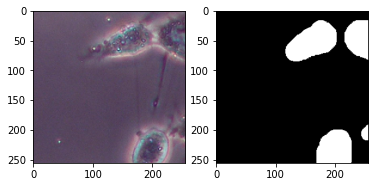

256 256 3


In [13]:
#Make sure the generator is working and that images and masks are indeed lined up. 
#Verify generator.... In python 3 next() is renamed as __next__()
x, y = train_img_gen.__next__()
for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()
    height, width, channels = image.shape
    print (height, width, channels)

Found 84 images belonging to 1 classes.
Found 84 images belonging to 1 classes.


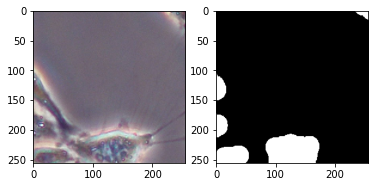

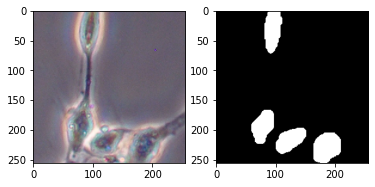

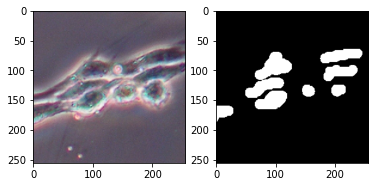

In [14]:
x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [15]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir(train_img_path+"train/"))
num_val_images = len(os.listdir(val_img_path+'val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

print("#Train Img: ", num_train_imgs)
print("#Val Img: ", num_val_images)
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)
n_classes=2

#Train Img:  252
#Val Img:  84
256
256
3


#Define, Compile, & Fit the Model

In [50]:
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
sm.set_framework('tf.keras')
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='sigmoid')
model.compile('Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
#print(model.summary())
print(model.input_shape)

(None, 256, 256, 3)


In [51]:
%xmode Verbose
#Fit the model
#Train the model. 
from segmentation_models.utils import set_regularization
checkpoint_filepath = cellseg_dir + "model/tmp/checkpoint_model.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_freq="epoch",
    save_weights_only=False
)
set_regularization(model, kernel_regularizer=keras.regularizers.l2(0.001),bias_regularizer=keras.regularizers.l2(0.001))
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=25,
          callbacks=[model_checkpoint_callback],
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

Exception reporting mode: Verbose
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 5 steps
Epoch 1/25
15/15 [==============================] - 21s 1s/step - loss: 0.8484 - iou_score: 0.2772 - val_loss: 2.2989 - val_iou_score: 0.0169
Epoch 2/25
15/15 [==============================] - 12s 797ms/step - loss: 0.7200 - iou_score: 0.3402 - val_loss: 1.1624 - val_iou_score: 0.4080
Epoch 3/25
15/15 [==============================] - 12s 792ms/step - loss: 0.6432 - iou_score: 0.4015 - val_loss: 0.8577 - val_iou_score: 0.4362
Epoch 4/25
15/15 [==============================] - 12s 776ms/step - loss: 0.5208 - iou_score: 0.5105 - val_loss: 0.8782 - val_iou_score: 0.4313
Epoch 5/25
15/15 [==============================] - 12s 794ms/step - loss: 0.4181 - iou_score: 0.6124 - val_loss: 0.6737 - val_iou_score: 0.4050
Epoch 6/25
15/15 [==============================] - 12s 784ms/step - loss: 0.3590 - iou_score: 0.6886 - val_loss: 0.6567 - val_iou_score: 0.4051
Epoch 7/

In [19]:
#Save model to drive
model.save(cellseg_dir + 'model/full/cellseg_25_epochs_RESNET_backbone_batch16.hdf5')

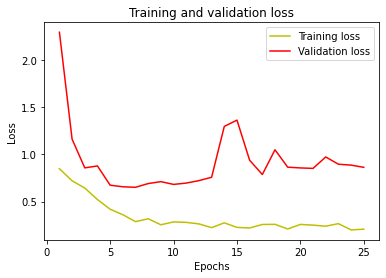

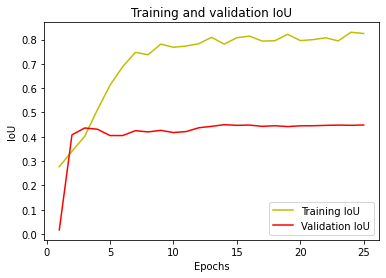

In [52]:
##################################################################
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

#####################################################

#Make Predictions

Mean IoU = 0.455976


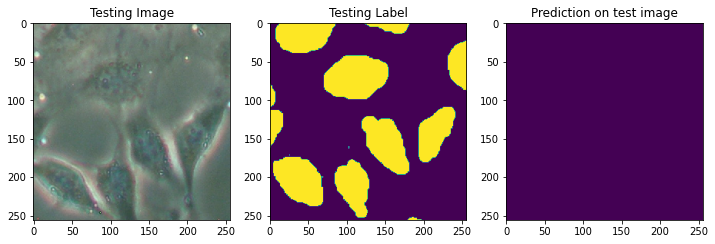

In [58]:
#batch_size=32 #Check IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()

In [20]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import smooth_tiled_predictions
from smooth_tiled_predictions import predict_img_with_smooth_windowing

In [21]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [22]:

img = cv2.imread(data_dir + "test/exp8.png")  #N-34-66-C-c-4-3.tif, N-34-97-D-c-2-4.tif
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
input_img = preprocess_input(input_img)

original_mask = cv2.imread(data_dir + "test/exp8-mask.png")
original_mask = original_mask[:,:,0]  #Use only single channel...
#original_mask = to_categorical(original_mask, num_classes=n_classes)

In [25]:
model = tf.keras.models.load_model("cellseg_25_epochs_RESNET_backbone_batch16.hdf5", compile=False)
                  
# size of patches
patch_size = 256

# Number of classes 
n_classes = 2

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [27]:
###################################################################################
#Predict using smooth blending

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)

100%|██████████| 8/8 [01:07<00:00,  8.45s/it]


In [28]:
final_prediction = np.argmax(predictions_smooth, axis=2)

#Save prediction and original mask for comparison
plt.imsave(data_dir+'test/exp8-prediction.jpg', final_prediction)
plt.imsave(data_dir+'test/exp8-original.jpg', original_mask)

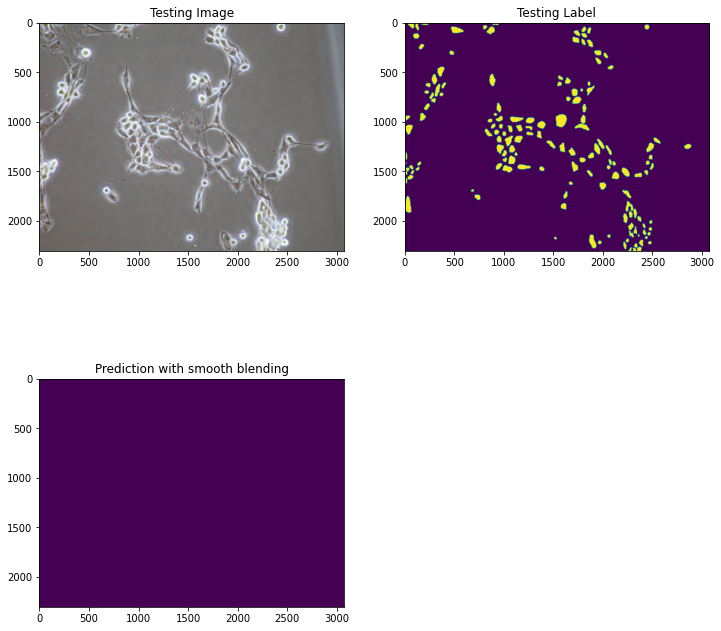

In [29]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(original_mask)
plt.subplot(223)
plt.title('Prediction with smooth blending')
plt.imshow(final_prediction)
plt.show()